### Extracting files from degrees.csv

In [2]:
import zipfile
import os

# Replace 'your_zip_file.zip' with the actual name of your zip file
zip_file_path = 'degrees.zip'

# Replace 'extracted_folder' with the name you want for the extracted folder
extracted_folder_path = 'degrees'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of zip file into a folder
    zip_ref.extractall(extracted_folder_path)

# List the files in the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print("Files extracted:", extracted_files)


Files extracted: ['degrees']


#### Nahi pata kaise kya hua

In [1]:
import csv
import sys
from collections import deque

# Data structures to store information from CSV files
names = {}
people = {}
movies = {}

def load_data(directory):
    # Load people data
    with open(f"{directory}/people.csv", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                person_id = int(row["id"])
                birth_year = int(row["birth"])
            except (ValueError, KeyError):
                # Skip the entire row if there's an error in data processing
                print(f"Skipping invalid entry: {row}")
                continue

            people[person_id] = {
                "name": row["name"],
                "birth": birth_year,
                "movies": set()
            }
            # Add name to names dictionary
            if row["name"].lower() not in names:
                names[row["name"].lower()] = {person_id}
            else:
                names[row["name"].lower()].add(person_id)

    # Load movies data
    with open(f"{directory}/movies.csv", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                movie_id = int(row["id"])
                release_year = int(row["year"])
            except (ValueError, KeyError):
                print(f"Skipping invalid entry: {row}")
                continue

            movies[movie_id] = {
                "title": row["title"],
                "year": release_year,
                "stars": set()
            }

    # Load stars data
    with open(f"{directory}/stars.csv", encoding="utf-8") as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                person_id = int(row["person_id"])
                movie_id = int(row["movie_id"])
            except ValueError:
                print(f"Skipping invalid entry: {row}")
                continue

            if person_id in people:
                people[person_id]["movies"].add(movie_id)

            if movie_id in movies:
                movies[movie_id]["stars"].add(person_id)


def person_id_for_name(name):
    person_ids = list(names.get(name.lower(), set()))
    if len(person_ids) == 0:
        print(f"No person found with the name '{name}'.")
        return None
    elif len(person_ids) > 1:
        print(f"Ambiguous name. Multiple people found with the name '{name}':")
        for person_id in person_ids:
            person = people[person_id]
            name = person["name"]
            birth = person["birth"]
            print(f"ID: {person_id}, Name: {name}, Birth: {birth}")
        try:
            person_id = input("Intended Person ID: ")
            if person_id in person_ids:
                return person_id
        except ValueError:
            pass
        return None
    else:
        return person_ids[0]

def shortest_path(source, target, method="bfs"):
    # Validate source and target names
    source_id = person_id_for_name(source)
    target_id = person_id_for_name(target)

    if source_id is None or target_id is None:
        sys.exit("Invalid source or target person. Exiting.")

    # Initialize data structures based on the specified method
    visited = set()
    frontier = QueueFrontier() if method == "bfs" else StackFrontier()
    frontier.add(Node(state=source_id, parent=None, action=None))

    while not frontier.empty():
        current_node = frontier.remove()
        current_id = current_node.state

        if current_id in visited:
            continue

        # Mark current person or movie as visited
        visited.add(current_id)

        # Add the current person or movie to the path
        if current_id in movies:
            current_name = movies[current_id]["title"]
        elif current_id in people:
            current_name = people[current_id]["name"]
        else:
            continue

        current_path = current_node.action + [current_name] if current_node.action else [current_name]

        # Check if we reached the target person
        if current_id == target_id:
            return current_path

        # Enqueue or stack neighbors for exploration
        neighbors = people[current_id]["movies"] if current_id in people else movies[current_id]["stars"]
        for neighbor_id in neighbors:
            if neighbor_id not in visited:
                frontier.add(Node(state=neighbor_id, parent=current_node, action=current_path))

    print(f"Target person '{target}' not found. Exiting.")
    return None

def main(directory):
    load_data(directory)

    source = input("Enter the source name: ")
    target = input("Enter the target name: ")

    # Using BFS
    bfs_path = shortest_path(source, target, "bfs")
    print(f"\nShortest path using BFS: {bfs_path}")

    # Using DFS
    dfs_path = shortest_path(source, target, "dfs")
    print(f"Shortest path using DFS: {dfs_path}")

if __name__ == "__main__":
    main("Week2/degrees/small")

Enter the source name: King
Enter the target name: Jenga
No person found with the name 'King'.
No person found with the name 'Jenga'.


SystemExit: Invalid source or target person. Exiting.

/Users/ashrutarora/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Q1)

In [11]:
import csv
from collections import deque

class Node():
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

class StackFrontier():
    def __init__(self):
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[-1]
            self.frontier = self.frontier[:-1]
            return node

class QueueFrontier(StackFrontier):

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[0]
            self.frontier = self.frontier[1:]
            return node

# Maps names to a set of corresponding person_ids
names = {}

# Maps person_ids to a dictionary of: name, birth, movies (a set of movie_ids)
people = {}

# Maps movie_ids to a dictionary of: title, year, stars (a set of person_ids)
movies = {}

def load_data(directory):
    """
    Load data from CSV files into memory.
    """
    # Load people
    with open(f"{directory}/people.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            people[row["id"]] = {
                "name": row["name"],
                "birth": row["birth"],
                "movies": set()
            }
            if row["name"].lower() not in names:
                names[row["name"].lower()] = {row["id"]}
            else:
                names[row["name"].lower()].add(row["id"])

    # Load movies
    with open(f"{directory}/movies.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            movies[row["id"]] = {
                "title": row["title"],
                "year": row["year"],
                "stars": set()
            }

    # Load stars
    with open(f"{directory}/stars.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                people[row["person_id"]]["movies"].add(row["movie_id"])
                movies[row["movie_id"]]["stars"].add(row["person_id"])
            except KeyError:
                pass

def main(directory="small"):
    # Load data from files into memory
    print("Loading data...")
    load_data(directory)
    print("Data loaded.")

    source = person_id_for_name(input("Name: "))
    if source is None:
        sys.exit("Person not found.")
    target = person_id_for_name(input("Name: "))
    if target is None:
        sys.exit("Person not found.")

    path_bfs = shortest_path(source, target, bfs=True)
    path_dfs = shortest_path(source, target, bfs=False)

    print("\nUsing Breadth-First Search:")
    print_path(path_bfs)

    print("\nUsing Depth-First Search:")
    print_path(path_dfs)

def shortest_path(source, target, bfs=True):
    """
    Returns the shortest list of (movie_id, person_id) pairs
    that connect the source to the target.

    If no possible path, returns None.
    """
    start = Node(state=source, parent=None, action=None)
    
    if bfs:
        frontier = QueueFrontier()
    else:
        frontier = StackFrontier()
    
    frontier.add(start)
    explored = set()

    while not frontier.empty():
        node = frontier.remove()
        person_id = node.state

        if person_id == target:
            path = []
            while node.parent is not None:
                path.append((node.action, node.state))
                node = node.parent
            path.reverse()
            return path

        explored.add(person_id)

        for movie_id, neighbor_id in neighbors_for_person(person_id):
            if neighbor_id not in explored and not frontier.contains_state(neighbor_id):
                child = Node(state=neighbor_id, parent=node, action=movie_id)
                frontier.add(child)

    return None

def print_path(path):
    if path is None:
        print("Not connected.")
        return []

    degrees = len(path)
    print(f"{degrees} degrees of separation.")
    formatted_path = []
    path = [(None, path[0][1])] + path
    for i in range(degrees):
        person1 = people[path[i][1]]["name"]
        person2 = people[path[i + 1][1]]["name"]
        movie = movies[path[i + 1][0]]["title"]
        formatted_str = f"{i + 1}: {person1} and {person2} starred in {movie}"
        print(formatted_str)
        formatted_path.append(formatted_str)

    return formatted_path

def person_id_for_name(name):
    """
    Returns the IMDB id for a person's name,
    resolving ambiguities as needed.
    """
    person_ids = list(names.get(name.lower(), set()))
    if len(person_ids) == 0:
        return None
    elif len(person_ids) > 1:
        print(f"Which '{name}'?")
        for person_id in person_ids:
            person = people[person_id]
            name = person["name"]
            birth = person["birth"]
            print(f"ID: {person_id}, Name: {name}, Birth: {birth}")
        try:
            person_id = input("Intended Person ID: ")
            if person_id in person_ids:
                return person_id
        except ValueError:
            pass
        return None
    else:
        return person_ids[0]

def neighbors_for_person(person_id):
    """
    Returns (movie_id, person_id) pairs for people
    who starred with a given person.
    """
    movie_ids = people[person_id]["movies"]
    neighbors = set()
    for movie_id in movie_ids:
        for person_id in movies[movie_id]["stars"]:
            neighbors.add((movie_id, person_id))
    return neighbors

if __name__ == "__main__":
    main("Week2/degrees/small")

Loading data...
Data loaded.
Name: Tom Cruise
Name: Valeria Golino

Using Breadth-First Search:
1 degrees of separation.
1: Valeria Golino and Valeria Golino starred in Rain Man

Using Depth-First Search:
1 degrees of separation.
1: Valeria Golino and Valeria Golino starred in Rain Man


## Q2)

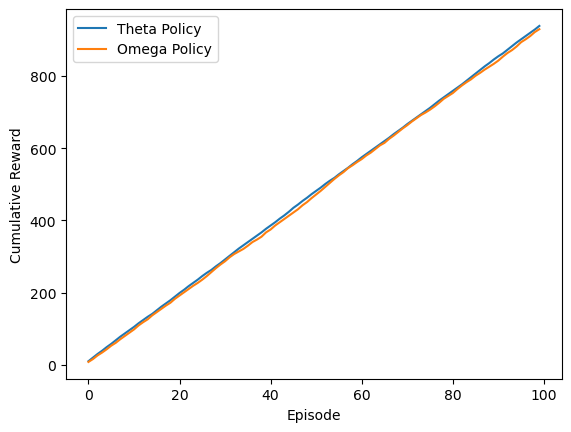

Theta policy: average reward = 9.39, std = 0.5812916651733446
Omega policy: average reward = 9.3, std = 1.1958260743101397


In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

# Initialize the environment
env = gym.make('CartPole-v1', render_mode='human')

def run_episode(policy, render=False):
    
    observation = env.reset()
    total_reward = 0
    
    for _ in range(100):
        
        if render:
            
            env.render()
            
        action = policy(observation)
        result = env.step(action)
        
        if len(result) == 5:
            
            observation, reward, terminated, truncated, info = result
            if terminated or truncated:
                break
            total_reward += reward
            
        else:
            print("env.step(action) did not return 5 values")
            break
    return total_reward, info

def theta_policy(observation):
    
    if isinstance(observation, tuple) and len(observation) == 2 and 'array' in str(type(observation[0])):
        theta = observation[0][2]
        return 0 if theta < 0 else 1
    else:
        return 0  # or whatever default action you want to take

def omega_policy(observation):
    
    if isinstance(observation, tuple) and len(observation) == 2 and 'array' in str(type(observation[0])):
        omega = observation[0][3]
        return 0 if omega < 0 else 1
    else:
        return 0  # or whatever default action you want to take

def evaluate_policy(policy, n_episodes=100, render=False):
    
    total_rewards = []
    for episode in range(n_episodes):
        
        episode_reward, info = run_episode(policy, render)
        total_rewards.append(episode_reward)
        
        if 'TimeLimit.truncated' in info and info['TimeLimit.truncated']:
            print(f"Episode {episode + 1}: Truncated due to time limit")
            
        elif 'TimeLimit.truncated' in info and info['TimeLimit.truncated']:
            print(f"Episode {episode + 1}: Terminated")
            
    return total_rewards

# Run episodes for Theta policy
theta_rewards = evaluate_policy(theta_policy)
theta_cumulative_rewards = np.cumsum(theta_rewards)
theta_average_reward = np.mean(theta_rewards)
theta_std_deviation = np.std(theta_rewards)

# Run episodes for Omega policy
omega_rewards = evaluate_policy(omega_policy)
omega_cumulative_rewards = np.cumsum(omega_rewards)
omega_average_reward = np.mean(omega_rewards)
omega_std_deviation = np.std(omega_rewards)

# Plot cumulative rewards
plt.plot(theta_cumulative_rewards, label='Theta Policy')
plt.plot(omega_cumulative_rewards, label='Omega Policy')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

# Print average rewards with standard deviation
print(f"Theta policy: average reward = {theta_average_reward}, std = {theta_std_deviation}")
print(f"Omega policy: average reward = {omega_average_reward}, std = {omega_std_deviation}")

# Close the environment window after visualization
env.close()

In [2]:
env.close()